# CUSUM

### Import data from csv

In [1]:
import pandas as pd
percentiles = pd.read_csv('mv.csv', sep=',',header=None, skip_blank_lines=False)
percentiles = percentiles.sort_values([2, 1, 0])
percentiles.columns = ['date', 'measure', 'id', 'percentile']
percentiles = percentiles.set_index('id') #(['measure', 'id', 'date'])
percentiles = percentiles[pd.notnull(percentiles.index)].reset_index()
percentiles = percentiles.set_index(['measure', 'id', 'date'])
percentiles = percentiles.unstack(level=2)
percentiles.columns = percentiles.columns.droplevel(0)
percentiles

date            2010-08-01  2010-09-01  2010-10-01  2010-11-01  2010-12-01  \
measure id                                                                   
ace     A81001    0.000000    0.000000    0.000000    0.000000    0.000000   
        A81002    0.000000    0.000000    0.000000   48.324405   47.140187   
        A81003    0.000000    0.000000    0.000000    0.000000    0.000000   
        A81004   70.103478    0.000000   79.444375    0.000000   67.003115   
        A81005   55.928189   67.946640   55.649682   70.686433   66.915888   
        A81006   47.999003   47.450443   47.801171   47.950667   51.439252   
        A81007   58.296970   51.863857    0.000000   53.058428    0.000000   
        A81008   67.896771   66.176287   84.327893   68.356796   66.753894   
        A81009    0.000000    0.000000    0.000000   49.283668    0.000000   
        A81011   51.165690   47.113826    0.000000    0.000000    0.000000   
        A81012   71.799028    0.000000    0.000000    0.000000   69.358255   
        A81013   64.306196   76.474255   52.684689   73.589137   80.112150   
        A81014   52.811370   52.487221   52.933848   53.145633   51.551402   
        A81015    0.000000    0.000000    0.000000    0.000000   63.725857   
        A81016    0.000000    0.000000    0.000000    0.000000   60.174455   
        A81017   54.644059   71.013589   46.954030   47.427432   46.417445   
        A81018    0.000000    0.000000    0.000000   88.177401    0.000000   
        A81019   55.404563    0.000000   54.939579    0.000000   52.809969   
        A81020   72.522129   55.953123    0.000000   57.144637   70.616822   
        A81021    0.000000   51.564643    0.000000    0.000000    0.000000   
        A81022   58.471512   61.625732   58.178647   51.949670   56.137072   
        A81023    0.000000    0.000000    0.000000    0.000000    0.000000   
        A81025   74.915846   72.858746   77.538308   76.429550   81.619938   
        A81026   52.050866   77.172422    0.000000   79.282422   50.180685   
        A81027   53.222790   73.606782   53.419708   81.163573   51.875389   
        A81029   65.066700    0.000000   64.420082    0.000000   61.532710   
        A81030   54.993143   67.497818   75.794195    0.000000   73.831776   
        A81031   50.654532   56.663758    0.000000   68.755450   68.635514   
        A81032   48.285750    0.000000    0.000000    0.000000    0.000000   
        A81033    0.000000    0.000000    0.000000    0.000000    0.000000   
...                    ...         ...         ...         ...         ...   
vitb    Y05167         NaN         NaN         NaN         NaN         NaN   
        Y05212         NaN         NaN         NaN         NaN         NaN   
        Y05238         NaN         NaN         NaN         NaN         NaN   
        Y05239         NaN         NaN         NaN         NaN         NaN   
        Y05240         NaN         NaN         NaN         NaN         NaN   
        Y05248         NaN         NaN         NaN         NaN         NaN   
        Y05250         NaN         NaN         NaN         NaN         NaN   
        Y05251         NaN         NaN         NaN         NaN         NaN   
        Y05252         NaN         NaN         NaN         NaN         NaN   
        Y05253         NaN         NaN         NaN         NaN         NaN   
        Y05257         NaN         NaN         NaN         NaN         NaN   
        Y05258         NaN         NaN         NaN         NaN         NaN   
        Y05267         NaN         NaN         NaN         NaN         NaN   
        Y05268         NaN         NaN         NaN         NaN         NaN   
        Y05279         NaN         NaN         NaN         NaN         NaN   
        Y05286         NaN         NaN         NaN         NaN         NaN   
        Y05291         NaN         NaN         NaN         NaN         NaN   
        Y05317         NaN         NaN         NaN         NaN         NaN   
        Y05318        

### CUSUM

In [321]:
months_smoothing = 12
sensitivity = 5

# remove date labels from columns
percentiles_dates = percentiles.columns #save date labels for later
percentiles.columns = range(percentiles.shape[1])

# create necessary tables with same index
smax = pd.DataFrame(index=percentiles.index)
smin = pd.DataFrame(index=percentiles.index)
reference_percentile = pd.DataFrame(index=percentiles.index)
threshold = pd.DataFrame(index=percentiles.index)
alert = pd.DataFrame(index=percentiles.index)
not_alert = pd.DataFrame(index=percentiles.index)

# set initial values for s
smax[0] = 0
smin[0] = 0

# set initial reference percentile for each 
reference_percentile[0] = percentiles.ix[:,0:months_smoothing-1].mean(axis=1)
#set initial threshold
threshold[0] = percentiles.ix[:,0:months_smoothing-1].std(axis=1, ddof=0) * sensitivity
#threshold[0] = np.std(percentiles.ix[:,0:months_smoothing-1]) * sensitivity

# loop over months of data
for i in range(1,percentiles.shape[1]): #range(1,percentiles.shape[1]): 
    
    # logic to determine alerts from previous month
    alert = (smax[i-1] > threshold[i-1]) | (smin[i-1] < -threshold[i-1])
    not_alert = (smax[i-1] <= threshold[i-1]) & (smin[i-1] >= -threshold[i-1])
    ## I'm sure there's a way of doing without this ^ one,
        # just coudn't work out the syntax to slice pandas rows
        # based on the opposite of the array of boolean values
        
    # reference percentile and threshold:
    ##append previous value if no alert
    reference_percentile.ix[not_alert, i] = reference_percentile.ix[not_alert, i-1]
    threshold[i] = threshold[i-1]
    
    ## reset reference after alert
    reference_percentile.ix[alert, i] = percentiles.ix[alert,i-months_smoothing:i-1].mean(axis=1)
    
    # CUSUM calculation (adding on previous s values done elsewhere)
    ##threshold[[i]] / sensitivity is a way of deriving stdev without generating it again
    smax[i] = percentiles[i] - (reference_percentile[i] + (0.5 * threshold[i] / sensitivity))
    smin[i] = percentiles[i] - (reference_percentile[i] - (0.5 * threshold[i] / sensitivity))
    
    # retrigger logic
    retrigger_pos = (smax[i] > 0) & (smax[i-1] > threshold[i-1])
    retrigger_neg = (smin[i] < 0) & (smin[i-1] < -threshold[i-1])
    cont_cumulative = not_alert|retrigger_pos|retrigger_neg
    thres_res = alert!=retrigger_pos|retrigger_neg
    
    # reset threshold
    threshold.ix[thres_res, i] = percentiles.ix[thres_res,i-months_smoothing:i-1].std(axis=1, ddof=0) * sensitivity
    
    # add s from previous month if no trigger, or retrigger
    smax.ix[cont_cumulative, i] = smax.ix[cont_cumulative, i] + smax.ix[cont_cumulative, i-1]
    smin.ix[cont_cumulative, i] = smin.ix[cont_cumulative, i] + smin.ix[cont_cumulative, i-1]
    
    # set baselines of zero
    smax.ix[smax[i] < 0, i] = 0
    smin.ix[smin[i] > 0, i] = 0

# determine &export alerts
alert_pos = (smax > threshold)
alert_pos.to_csv('alert_pos_pandas.csv')

alert_neg = (smin < -threshold)
alert_neg.to_csv('alert_neg_pandas.csv')

# other potentially useful outputs (for drawing graphs etc)
#smax
#smin
#percentile
#reference_percentile
#threshold

0          1          2          3          4          5   \
measure id                                                                  
ace     A81001   0   0.000000   0.000000   0.000000   0.000000  45.855316   
        A81002   0   0.000000   0.000000  11.160265  21.136313   0.000000   
        A81003   0   0.000000   0.000000   0.000000   0.000000   0.000000   
        A81004   0   0.000000  16.860001   0.000000   4.418741  23.440843   
        A81005   0   0.000000   0.000000   1.417499   0.000000   0.000000   
        A81006   0   0.000000   0.000000   0.000000   0.000000   0.000000   
        A81007   0   7.155475   0.000000   8.350045   0.000000   9.700086   
        A81008   0   0.000000  11.342112   6.713127   0.481240   0.000000   
        A81009   0   0.000000   0.000000  19.439008   0.000000   0.000000   
        A81011   0  13.971740   0.000000   0.000000   0.000000  15.836744   
        A81012   0   0.000000   0.000000   0.000000  27.790205   0.000000   
        A81013   0   0.000000   0.000000   0.000000   0.332625   1.188218   
        A81014   0   0.000000   0.000000   0.000000   0.000000   0.000000   
        A81015   0   0.000000   0.000000   0.000000  41.148930  18.572004   
        A81016   0   0.000000   0.000000   0.000000  46.844247  33.514038   
        A81017   0  12.408679   0.757800   0.000000   0.000000   0.000000   
        A81018   0   0.000000   0.000000  68.643811  49.110221  29.576632   
        A81019   0   0.000000   8.813055   0.000000   6.683445  18.402501   
        A81020   0   0.000000   0.000000   0.000000   5.765855   0.329582   
        A81021   0  40.141732  28.718821  17.295911   5.873000   0.000000   
        A81022   0   3.379831   3.312577   0.000000   0.000000   0.000000   
        A81023   0   0.000000   0.000000   0.000000   0.000000   0.000000   
        A81025   0   0.000000   0.000000   0.000000   2.585228   0.000000   
        A81026   0   5.094044   0.000000   7.204043   0.000000  10.325108   
        A81027   0   0.716685   0.000000   8.273476   0.000000   1.630451   
        A81029   0   0.000000  10.494945   0.000000   7.607573   0.000000   
        A81030   0   0.000000   0.902324   0.000000   0.000000   1.758192   
        A81031   0   4.663352   0.000000  16.755045  33.390154   0.000000   
        A81032   0   0.000000   0.000000   0.000000   0.000000   0.000000   
        A81033   0   0.000000   0.000000   0.000000   0.000000   0.000000   
...             ..        ...        ...        ...        ...        ...   
vitb    Y05167   0        NaN        NaN        NaN        NaN        NaN   
        Y05212   0        NaN        NaN        NaN        NaN        NaN   
        Y05238   0        NaN        NaN        NaN        NaN        NaN   
        Y05239   0        NaN        NaN        NaN        NaN        NaN   
        Y05240   0        NaN        NaN        NaN        NaN        NaN   
        Y05248   0        NaN        NaN        NaN        NaN        NaN   
        Y05250   0        NaN        NaN        NaN        NaN        NaN   
        Y05251   0        NaN        NaN        NaN        NaN        NaN   
        Y05252   0        NaN        NaN        NaN        NaN        NaN   
        Y05253   0        NaN        NaN        NaN        NaN        NaN   
        Y05257   0        NaN        NaN        NaN        NaN        NaN   
        Y05258   0        NaN        NaN        NaN        NaN        NaN   
        Y05267   0        NaN        NaN        NaN        NaN        NaN   
        Y05268   0        NaN        NaN        NaN        NaN        NaN   
        Y05279   0        NaN        NaN        NaN        NaN        NaN   
        Y05286   0        NaN        NaN        NaN        NaN        NaN   
        Y05291   0        NaN        NaN        NaN        NaN        NaN   
        Y05317   0        NaN        NaN        NaN        NaN        NaN   
        Y05318   0        NaN        NaN        NaN        NaN        NaN   
        Y053

### Draw plot to ensure it's the same as previous method

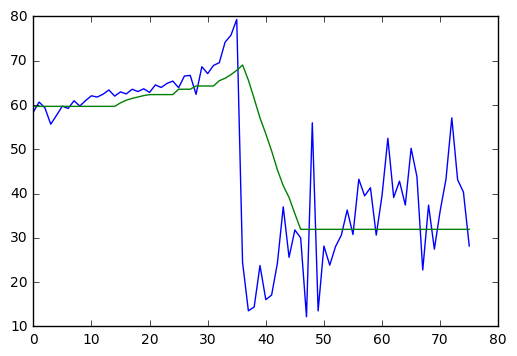

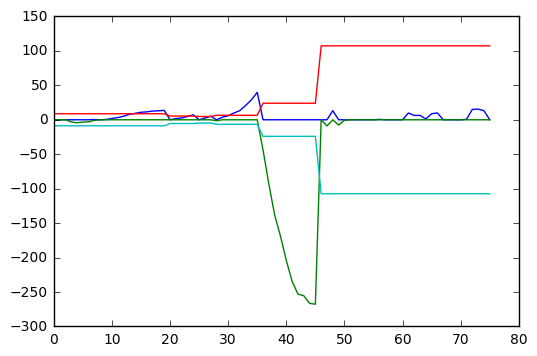

In [322]:
import matplotlib.pyplot as plt
location = 'N85051'
measure = 'cerazette'
plt.plot(percentiles.loc[measure, location])
plt.plot(reference_percentile.loc[measure, location])
plt.show()

plt.plot(smax.loc[measure, location])
plt.plot(smin.loc[measure, location])
plt.plot(threshold.loc[measure, location])
plt.plot(-threshold.loc[measure, location])
plt.show()